In [1]:
from astroquery.vizier import Vizier
from astroquery.sdss import SDSS
import astropy.units as u
from astropy import coordinates as coords
from astropy.table import Table, hstack, vstack
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from synphot import SourceSpectrum
from synphot.models import Empirical1D
from synphot import units
import random
import os.path
from collections import Counter
from specutils import Spectrum1D, SpectralRegion
from specutils.analysis import snr_derived


In [344]:
# Search Vizier for latest SDSS quasar catalog 'DR16Q': (Lyke+, 2020)'
catalog_list = Vizier.find_catalogs('DR16Q')
print({k:v.description for k,v in catalog_list.items()})


{'VII/289': 'SDSS quasar catalog, sixteenth data release (DR16Q) (Lyke+, 2020)'}


In [345]:
# Check index/name of quasar-only
Vizier.ROW_LIMIT = 50
catalogs = Vizier.get_catalogs(catalog_list.keys())
print(catalogs)


TableList with 2 tables:
	'0:VII/289/dr16q' with 39 column(s) and 50 row(s) 
	'1:VII/289/superset' with 12 column(s) and 50 row(s) 


In [346]:
# Get 'SDSS quasar-only catalog (750414 rows)'
Vizier.ROW_LIMIT = -1
DR16Q = Vizier.get_catalogs('VII/289/dr16q')[0]
print(len(DR16Q))


750414


In [348]:
DR16Q.write('tables/dr16q.ecsv')


In [350]:
DR16Q=Table.read('tables/dr16q.ecsv')


In [347]:
# Example, _tab1_5 = MJD
DR16Q[0:2]


SDSS,RAJ2000,DEJ2000,Plate,_tab1_5,Fiber,Class,QSO,z,r_z,umag,gmag,rmag,imag,zmag,e_umag,e_gmag,e_rmag,e_imag,e_zmag,Extu,Extg,Extr,Exti,Extz,FFUV,FNUV,FY,FJ,FH,FK,FW1,fracW1,FW2,fracW2,_2RXS,Gaia,Sp,Simbad
,deg,deg,,,,,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,3.63 uJy,3.63 uJy,W/m2/Hz,W/m2/Hz,W/m2/Hz,W/m2/Hz,309.05 nJy,,167.66 nJy,,,,,
str18,float64,float64,int32,int32,int16,int16,uint8,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str16,int64,str2,str6
000000.15+353104.2,0.000629,35.517841,7750,58402,802,0,1,0.845435,PIPE,18.9640,18.6307,18.4295,18.4118,18.2555,0.024823,0.013814,0.017368,0.017177,0.028182,0.343751,0.267848,0.185296,0.137695,0.102420,4.1486,14.4419,--,--,--,--,1663.6,0.839185,4714.7,0.853671,,2875546163053982464,Sp,Simbad
000000.33+310325.3,0.001415,31.057048,7749,58073,660,0,1,2.035491,PIPE,22.0825,21.7871,21.5621,21.3595,20.9340,0.13819,0.046183,0.050452,0.060369,0.18578,0.198869,0.154957,0.107199,0.079660,0.059253,0.2793,0.1652,--,--,--,--,126.42,0.843524,267.47,0.855141,,--,Sp,Simbad


In [ ]:
# Pick 1000 random objects from the catalog
DR16Q_1k = DR16Q[random.sample(range(len(DR16Q)), 1000)]


In [352]:
DR16Q_1k.write('tables/dr16q_1k.ecsv')


In [2]:
DR16Q_1k=Table.read('tables/dr16q_1k.ecsv')
DR16Q_1k


SDSS,RAJ2000,DEJ2000,Plate,_tab1_5,Fiber,Class,QSO,z,r_z,umag,gmag,rmag,imag,zmag,e_umag,e_gmag,e_rmag,e_imag,e_zmag,Extu,Extg,Extr,Exti,Extz,FFUV,FNUV,FY,FJ,FH,FK,FW1,fracW1,FW2,fracW2,_2RXS,Gaia,Sp,Simbad
,deg,deg,,,,,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,3.63 uJy,3.63 uJy,W / (Hz m2),W / (Hz m2),W / (Hz m2),W / (Hz m2),309.05 nJy,,167.66 nJy,,,,,
str18,float64,float64,int32,int32,int16,int16,uint8,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str16,int64,str2,str6
011038.20-004750.2,17.659192,-0.797284,7875,56980,606,0,1,1.454324,PIPE,21.6054,21.4195,21.1258,20.7786,20.6651,0.10724,0.041826,0.043071,0.045918,0.11896,0.133143,0.103744,0.071770,0.053333,0.039670,0.1217,0.9385,1.516e-31,2.3558e-31,3.0187e-31,3.249e-31,133.49,0.848283,533.37,0.891650,--,2532986787069382144,Sp,Simbad
074325.64+325500.5,115.856870,32.916821,9365,57749,385,3,1,1.085000,VI,22.4927,22.2074,21.6756,21.6030,21.0151,0.19685,0.064317,0.058972,0.070352,0.14409,0.180757,0.140845,0.097436,0.072405,0.053856,0.2427,0.3749,--,--,--,--,242.8,0.846516,415.84,0.853221,--,--,Sp,Simbad
144300.02+551002.3,220.750085,55.167310,6711,56388,716,3,1,2.293000,VI,22.1664,21.3038,21.1089,21.2856,20.9127,0.16168,0.043441,0.055145,0.10665,0.25181,0.066725,0.051991,0.035967,0.026728,0.019880,-0.2282,0.1613,--,--,--,--,67.5,0.848067,287.2,0.857085,--,--,Sp,Simbad
001506.86+021047.6,3.778608,2.179915,7853,56988,898,0,1,1.238905,PIPE,20.0844,20.2391,19.8392,19.8148,19.8975,0.041342,0.024518,0.02335,0.025087,0.071048,0.129162,0.100642,0.069624,0.051738,0.038483,0.7273,4.8683,4.3129e-31,4.8232e-31,7.6595e-31,6.8314e-31,784.36,0.928406,2392.3,0.937647,--,2548232546580924672,Sp,Simbad
231212.46+312253.4,348.051944,31.381527,7764,58042,69,0,1,1.352666,PIPE,20.3849,20.3479,19.7603,19.6188,19.5765,0.046156,0.018157,0.0178,0.025056,0.068251,0.319405,0.248878,0.172173,0.127943,0.095166,1.2545,3.0857,--,--,--,--,264.82,0.882234,909.13,0.895280,--,1909842871291273984,Sp,Simbad
125650.85+574700.1,194.211891,57.783376,8213,58487,292,0,1,0.540363,PIPE,21.6130,21.3419,21.0642,20.5918,20.2888,0.12798,0.047145,0.047549,0.047931,0.11926,0.052457,0.040874,0.028277,0.021013,0.015630,2.4283,2.7247,--,--,--,--,369.59,0.924773,706.22,0.921861,--,--,Sp,Simbad
102816.32+302945.9,157.068004,30.496086,11383,58485,387,0,1,1.612184,PIPE,21.6755,21.5629,21.6922,21.7425,21.5773,0.13466,0.063853,0.086073,0.21935,0.38832,0.075934,0.059167,0.040932,0.030417,0.022624,1.2347,1.7088,--,--,--,--,111.06,0.843342,345.3,0.854877,--,--,Sp,Simbad
141907.66+350900.1,214.781948,35.150050,3859,55246,356,3,1,1.436000,VI,20.6336,20.2456,19.6718,19.3594,19.2067,0.052708,0.022351,0.018836,0.020635,0.054709,0.070443,0.054888,0.037972,0.028217,0.020988,0.1579,0.9151,--,--,--,--,502.97,0.927103,1452.9,0.936341,--,1480660322842263424,Sp,Simbad


In [20]:
# Download QSO spectrum files:
import os.path
error = []
for l in range(len(DR16Q_1k)):
        plate = DR16Q_1k[l]['Plate']
        mjd = DR16Q_1k[l]['_tab1_5']
        fiber = DR16Q_1k[l]['Fiber']
        filename = 'spec-'+str(plate).zfill(4)+'-'+str(mjd)+'-'+str(fiber).zfill(4)+'.fits'
        if not os.path.exists('SDSSspec/'+filename):
            try:
                spec = SDSS.get_spectra(plate=plate, mjd=mjd, fiberID=fiber, data_release=17)
                spec[0].writeto('SDSSspec/'+filename)
            except:
                csv_row = str(plate).zfill(4)+', '+str(mjd)+', '+str(fiber).zfill(4)
                error.append(csv_row)

with open('SDSSspec/error.txt', 'w') as f:
    for element in error:
        f.write(element + "\n")


C:\Users\AntonioOrtega\AppData\Local\Programs\Python\Python39\lib\site-packages\astroquery\sdss\core.py:867: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


In [29]:
# Download Error because of internal query. Direct HTTP download
# SELECT DISTINCT s.run2d, s.plate, s.mjd, s.fiberID FROM PhotoObjAll AS p JOIN SpecObjAll s ON p.objID = s.bestObjID 
# WHERE (s.plate= AND s.mjd= AND s.fiberid=)'
p, m, f = 1435, 52996, 426

from astroquery.utils import commons as acomm
filename = 'spec-'+str(p).zfill(4)+'-'+str(m)+'-'+str(f).zfill(4)+'.fits'
query = "SELECT run2d FROM SpecObjAll WHERE plate="+str(p)+" AND mjd="+str(m)+" AND fiberid="+str(f)
res = SDSS.query_sql(query, data_release=17)
r2d = res[0]['run2d']
link = 'https://data.sdss.org/sas/dr17/sdss/spectro/redux/'+str(r2d)+'/spectra/'+str(p).zfill(4)+'/'+filename
spec = acomm.FileContainer(link,encoding='binary',remote_timeout=60,show_progress=True).get_fits()
spec.writeto('SDSSspec/'+filename)


In [4]:
# Joint table, with class and subclass, and snr
DR16Q_1k_class = Table()
obtyp = Table(names=('class', 'subclass', 'sppixmask', 'zwarning', 'good', 'snr'), dtype=('S10', 'S10', 'S100', 'S100', 'bool', 'f8'))
for i in range(len(DR16Q_1k)):
    bitset_m = set()
    bitset_z = set()
    p = DR16Q_1k[i]['Plate']
    m = DR16Q_1k[i]['_tab1_5']
    f = DR16Q_1k[i]['Fiber']
    filename = 'spec-'+str(p).zfill(4)+'-'+str(m)+'-'+str(f).zfill(4)+'.fits'
    spec1d = Spectrum1D.read('dr16q_1k/'+filename)
    snrval = snr_derived(spec1d, SpectralRegion(4000*u.AA, 9000*u.AA))
    hdul = fits.open('dr16q_1k/'+filename)
    andmk = hdul[1].data['and_mask']
    zwarn = hdul[2].data['ZWARNING']
    counter = 0
    for v in range(len(zwarn)):
        bits = [bit for bit in range(0, 32) if (zwarn[v] & 1 << bit) > 0]
        if bits!=[]:
            bitset_z.update(bits)
    for v in range(len(andmk)):
        bits = [bit for bit in range(0, 32) if (andmk[v] & 1 << bit) > 0]
        if bits!=[]:
            if bits!=[]: counter=counter+1
            bitset_m.update(bits)
    badpct = counter/len(andmk)
    goodfl = True
    if badpct>0.1:
        goodfl = False
    obtyp.add_row((hdul[2].data['CLASS'][0], hdul[2].data['SUBCLASS'][0], str(bitset_m), str(bitset_z), goodfl, snrval))
DR16Q_1k_class = hstack([DR16Q_1k, obtyp])


In [5]:
DR16Q_1k_class.write('tables/dr16q_1k_class.ecsv', overwrite=True)


In [6]:
DR16Q_1k_class=Table.read('tables/dr16q_1k_class.ecsv')
DR16Q_1k_class


SDSS,RAJ2000,DEJ2000,Plate,_tab1_5,Fiber,Class,QSO,z,r_z,umag,gmag,rmag,imag,zmag,e_umag,e_gmag,e_rmag,e_imag,e_zmag,Extu,Extg,Extr,Exti,Extz,FFUV,FNUV,FY,FJ,FH,FK,FW1,fracW1,FW2,fracW2,_2RXS,Gaia,Sp,Simbad,class,subclass,sppixmask,zwarning,good,snr
,deg,deg,,,,,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,3.63 uJy,3.63 uJy,W / (Hz m2),W / (Hz m2),W / (Hz m2),W / (Hz m2),309.05 nJy,,167.66 nJy,,,,,,,,,,,
str18,float64,float64,int32,int32,int16,int16,uint8,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str16,int64,str2,str6,str6,str19,str28,str6,bool,float64
011038.20-004750.2,17.659192,-0.797284,7875,56980,606,0,1,1.454324,PIPE,21.6054,21.4195,21.1258,20.7786,20.6651,0.10724,0.041826,0.043071,0.045918,0.11896,0.133143,0.103744,0.071770,0.053333,0.039670,0.1217,0.9385,1.516e-31,2.3558e-31,3.0187e-31,3.249e-31,133.49,0.848283,533.37,0.891650,--,2532986787069382144,Sp,Simbad,QSO,BROADLINE,"{27, 23}",set(),True,3.5506450787574013
074325.64+325500.5,115.856870,32.916821,9365,57749,385,3,1,1.085000,VI,22.4927,22.2074,21.6756,21.6030,21.0151,0.19685,0.064317,0.058972,0.070352,0.14409,0.180757,0.140845,0.097436,0.072405,0.053856,0.2427,0.3749,--,--,--,--,242.8,0.846516,415.84,0.853221,--,--,Sp,Simbad,QSO,--,{23},{2},True,1.1169608473719579
144300.02+551002.3,220.750085,55.167310,6711,56388,716,3,1,2.293000,VI,22.1664,21.3038,21.1089,21.2856,20.9127,0.16168,0.043441,0.055145,0.10665,0.25181,0.066725,0.051991,0.035967,0.026728,0.019880,-0.2282,0.1613,--,--,--,--,67.5,0.848067,287.2,0.857085,--,--,Sp,Simbad,QSO,BROADLINE,"{16, 19, 23}",set(),True,3.9312597494296577
001506.86+021047.6,3.778608,2.179915,7853,56988,898,0,1,1.238905,PIPE,20.0844,20.2391,19.8392,19.8148,19.8975,0.041342,0.024518,0.02335,0.025087,0.071048,0.129162,0.100642,0.069624,0.051738,0.038483,0.7273,4.8683,4.3129e-31,4.8232e-31,7.6595e-31,6.8314e-31,784.36,0.928406,2392.3,0.937647,--,2548232546580924672,Sp,Simbad,QSO,BROADLINE,"{27, 23}",set(),True,9.415525186909598
231212.46+312253.4,348.051944,31.381527,7764,58042,69,0,1,1.352666,PIPE,20.3849,20.3479,19.7603,19.6188,19.5765,0.046156,0.018157,0.0178,0.025056,0.068251,0.319405,0.248878,0.172173,0.127943,0.095166,1.2545,3.0857,--,--,--,--,264.82,0.882234,909.13,0.895280,--,1909842871291273984,Sp,Simbad,QSO,BROADLINE,"{18, 23}",set(),True,10.432438984992652
125650.85+574700.1,194.211891,57.783376,8213,58487,292,0,1,0.540363,PIPE,21.6130,21.3419,21.0642,20.5918,20.2888,0.12798,0.047145,0.047549,0.047931,0.11926,0.052457,0.040874,0.028277,0.021013,0.015630,2.4283,2.7247,--,--,--,--,369.59,0.924773,706.22,0.921861,--,--,Sp,Simbad,QSO,--,{23},set(),True,2.8094791557669834
102816.32+302945.9,157.068004,30.496086,11383,58485,387,0,1,1.612184,PIPE,21.6755,21.5629,21.6922,21.7425,21.5773,0.13466,0.063853,0.086073,0.21935,0.38832,0.075934,0.059167,0.040932,0.030417,0.022624,1.2347,1.7088,--,--,--,--,111.06,0.843342,345.3,0.854877,--,--,Sp,Simbad,QSO,--,{23},set(),True,1.6567472481501833
141907.66+350900.1,214.781948,35.150050,3859,55246,356,3,1,1.436000,VI,20.6336,20.2456,19.6718,19.3594,19.2067,0.052708,0.022351,0.018836,0.020635,0.054709,0.070443,0.054888,0.037972,0.028217,0.020988,0.1579,0.9151,--,--,--,--,502.97,0.927103,1452.9,0.936341,--,1480660322842263424,Sp,Simbad,QSO,--,{23},set(),True,11.524729690957919


In [7]:
def plotspecq(plate, mjd, fiber, direc, title, g, c, save=False):
    filename = 'spec-'+str(plate).zfill(4)+'-'+str(mjd)+'-'+str(fiber).zfill(4)+'.fits'
    hdul = fits.open(direc+filename)
    flux = hdul[1].data['flux']*1e-17*units.FLAM
    loglam = hdul[1].data['loglam']
    wave = 10 ** loglam

    sp = SourceSpectrum(Empirical1D, points=wave, lookup_table=flux, keep_neg=False)
    spu = units.convert_flux(sp.waveset, sp(sp.waveset), units.FLAM)

    plt.figure(figsize=(16,4))
    plt.plot(sp.waveset.value, spu.value)
    plt.xlabel('Wavelength [Ångströms]')
    plt.ylabel('Flux [erg/cm²/s/Å]')
    plt.title(title+' ; '+hdul[2].data['CLASS'][0]+' '+hdul[2].data['SUBCLASS'][0])
    if save==True:
        if g==False:
            folderout='bad/'
        else:
            if c!='QSO':
                folderout='other/'
            else:
                folderout='spec/'
        plt.savefig(folderout+'spec-'+str(plate).zfill(4)+'-'+str(mjd)+'-'+str(fiber).zfill(4)+'.png', facecolor='white', edgecolor='none')
    else:
        plt.show()

def plotspec_obqs(object, save=False):
    p=object['Plate']
    m=object['_tab1_5']
    f=object['Fiber']
    t=object['SDSS']
    g=object['good']
    c=str(object['class'])
    plotspecq(p, m, f, 'dr16q_1k/', t+' ; '+str(p)+'-'+str(m)+'-'+str(f), g, c, save)


In [10]:
%%capture
# Plot (and save) spectrum loop
for l in range(len(DR16Q_1k_class)):
    plotspec_obqs(DR16Q_1k_class[l], save=True)


  points: [ 3610.7717  3619.9292  3627.439   3628.2734  3629.945   3630.78
  3632.453   3633.2903  3635.8005  3637.4756  3639.9885  3640.826
  3643.343   3644.1812  3645.0215  3649.2202  3655.1067  3655.9475
  3661.003   3664.3748  3672.8235  3698.2825  3699.1333  3705.9548
  3706.8074  3711.9329  3713.6409  3723.0593  3727.348   3753.1848
  3754.9138  3757.508   3758.3745  3760.106   3760.971   3769.6401
  3808.9043  3809.7805  3811.5356  3815.926   3816.806   3817.684
  3818.5623  3821.2024  3825.604   3830.0105  3830.8938  3831.7751
  3832.6565  3833.5403  3834.4224  3837.0735  3837.956   3838.839
  3839.7244  3843.263   3846.803   3857.4463  3859.2234  3860.1135
  3861.0015  4360.135   4817.26    5892.5044  5896.5786  5897.935
  7277.798   7343.448   7362.0728  7372.2485  7629.568   7631.327
  7638.356   7753.5376  7823.4795  7825.2837  7861.401   7883.152
  7915.894   8186.5327  8346.415   8348.34    8402.337   8431.405
  8433.35    8454.734   8625.813   8637.736   8655.655   8657

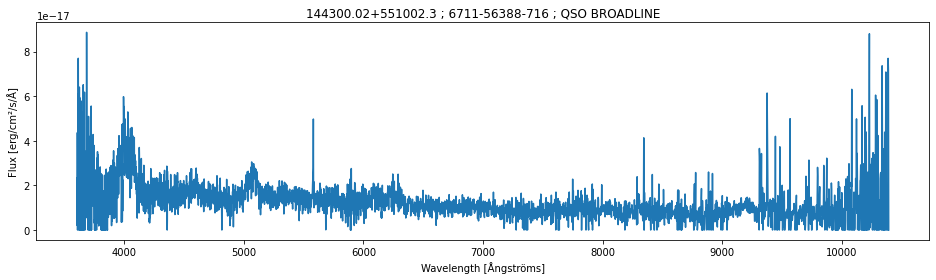

In [8]:
plotspec_obqs(DR16Q_1k_class[2], save=False)
